# Least squares method with native JAX functions

**Note**: This notebook is designed to run on CPU (no GPU) runtime.

**[LSJ-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.6/185.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.2 MB/s eta 0:00:00
flax                          0.6.1
jax                           0.3.25
jaxlib                        0.3.25+cuda11.cudnn805
optax                         0.1.3


**[LSJ-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

import jax
from jax import random, numpy as jnp

plt.rcParams.update({'font.size': 12})

**[LSJ-03]**

Prepare the ground truth labels.

**Note**: `jnp.asarray()` creates an `DeviceArray` object that is an extension of the numpy array. If the backend platform has GPUs, it's automatically stored in the GPU memory.

In [3]:
train_t = jnp.asarray([5.2, 5.7, 8.6, 14.9, 18.2, 20.4,
                       25.5, 26.4, 22.8, 17.5, 11.1, 6.6])
train_t = train_t.reshape([12, 1])
train_t

DeviceArray([[ 5.2],
             [ 5.7],
             [ 8.6],
             [14.9],
             [18.2],
             [20.4],
             [25.5],
             [26.4],
             [22.8],
             [17.5],
             [11.1],
             [ 6.6]], dtype=float32)

**[LSJ-04]**

Prepare the input data.

`train_x` contains the input values $(x^0, x^1, x^2, x^3, x^4)\ (x=1,\cdots,12)$ to the model in the design matrix form:

$$
\mathbf X = \begin{pmatrix}
1^0 & 1^1 & 1^2 & 1^3 & 1^4 \\
2^0 & 2^1 & 2^2 & 2^3 & 2^4 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
12^0 & 12^1 & 12^2 & 12^3 & 12^4
\end{pmatrix}
$$

In [4]:
train_x = jnp.asarray([[month**n for n in range(0, 5)]
                       for month in range(1, 13)])
train_x

DeviceArray([[    1,     1,     1,     1,     1],
             [    1,     2,     4,     8,    16],
             [    1,     3,     9,    27,    81],
             [    1,     4,    16,    64,   256],
             [    1,     5,    25,   125,   625],
             [    1,     6,    36,   216,  1296],
             [    1,     7,    49,   343,  2401],
             [    1,     8,    64,   512,  4096],
             [    1,     9,    81,   729,  6561],
             [    1,    10,   100,  1000, 10000],
             [    1,    11,   121,  1331, 14641],
             [    1,    12,   144,  1728, 20736]], dtype=int32)

**[LSJ-05]**

Define variables for weights and bias. They are the model parameters to be trained with the training dataset.

In [5]:
key, key1 = random.split(random.PRNGKey(0))
w = random.normal(key1, [5, 1])
w

DeviceArray([[-1.4581939],
             [-2.047044 ],
             [ 2.0473392],
             [ 1.1684095],
             [-0.9758364]], dtype=float32)

**[LSJ-06]**

Define a function (model) to predict the label value for a specific input `x` using the parameter values `w`.

In [6]:
@jax.jit
def predict(w, x):
    y = jnp.matmul(x, w)
    return y

**[LSJ-07]**

Define a loss function as the mean square error.

In [7]:
@jax.jit
def loss_fn(w, train_x, train_t):
    y = predict(w, train_x)
    loss = jnp.mean((y - train_t)**2)
    return loss

**[LSJ-08]**

Define the gradient of the loss function. The gradient is a function with the same input parameters as the loss function.

**Note 1**: `jax.grad()` calculates the gradient against the first parameter of the given function.

**Note 2**: `jax.jit()` precompiles the given function to produce a binary that can be executed on GPUs.

In [8]:
grad_loss = jax.jit(jax.grad(loss_fn))

**[LSJ-09]**

Apply the (naive) gradient descent algorithm to tune the parameters.

**Note**: You need to fine-tune `learning_rate` to get a good result with the naive gradient descent.

In [9]:
%%time
learning_rate = 1e-8 * 1.4
for step in range(1, 5000001):
    grads = grad_loss(w, train_x, train_t)
    w = w - learning_rate * grads
    if step % 500000 == 0:
        loss_val = loss_fn(w, train_x, train_t)
        print ('Step: {}, Loss: {:0.4f}'.format(step, loss_val),
               flush=True)

Step: 500000, Loss: 12.6795
Step: 1000000, Loss: 10.2526
Step: 1500000, Loss: 8.2854
Step: 2000000, Loss: 6.9154
Step: 2500000, Loss: 6.6278
Step: 3000000, Loss: 6.3830
Step: 3500000, Loss: 6.3830
Step: 4000000, Loss: 6.3830
Step: 4500000, Loss: 6.3830
Step: 5000000, Loss: 6.3830
CPU times: user 1min 13s, sys: 177 ms, total: 1min 13s
Wall time: 1min 16s


**[LSJ-10]**

Show weights after the training.

In [10]:
w

DeviceArray([[-1.4652629 ],
             [-1.6966996 ],
             [ 2.2171433 ],
             [-0.25951618],
             [ 0.00752223]], dtype=float32)

**[LSJ-11]**

Plot a chart for predictions.

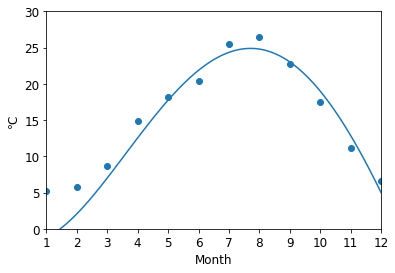

In [11]:
xs = np.linspace(1, 12, 100)
inputs = jnp.asarray([[month**n for n in range(0, 5)]
                      for month in xs])
ys = predict(w, inputs)

fig = plt.figure(figsize=(6, 4))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim(1, 12)
subplot.set_ylim(0, 30)
subplot.set_xticks(range(1, 13))
subplot.set_xlabel('Month')
subplot.set_ylabel('℃')

subplot.scatter(range(1, 13), train_t)
_ = subplot.plot(xs, ys)